In [1]:
from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/valsp/miniconda3/envs/tf/lib"


In [8]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import one_hot
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import KLDivergence
from sklearn import metrics
from model_helper import *
from pathlib import Path


## 1. Load in dataset

In [3]:
cwd = Path().cwd()

In [4]:
with open(cwd.parent / "preprocessing/training_seq_n_12_rmrp0", "rb") as f:
    train_data = pickle.load(f)
with open(cwd.parent / "preprocessing/dev_seq_n_12_rmrp0", "rb") as f:
    val_data = pickle.load(f)
with open(cwd.parent / "preprocessing/test_seq_n_12_rmrp0", "rb") as f:
    test_data = pickle.load(f)

In [37]:
X_train = np.array(train_data["X"])
print(f"X_train shape: {X_train.shape}")
Y_train = np.array(train_data["Y"]).reshape(-1, 1)
print(f"Y_train shape: {Y_train.shape}")
X_val = np.array(val_data["X"])
print(f"X_val shape: {X_val.shape}")
Y_val = np.array(val_data["Y"]).reshape(-1, 1)
print(f"Y_val shape: {Y_val.shape}")
X_test = np.array(test_data["X"])
print(f"X_test shape: {X_test.shape}")
Y_test = np.array(test_data["Y"]).reshape(-1, 1)
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (20157, 12, 22)
Y_train shape: (20157, 1)
X_val shape: (2442, 12, 22)
Y_val shape: (2442, 1)
X_test shape: (2497, 12, 22)
Y_test shape: (2497, 1)


## Load Model

In [9]:
def one_off_accuracy(y_true, y_pred):
    """Computes the accuracy of a grade prediction including +/-1 errors

    Args:
        y_true: true grades
        y_pred: predicted grades
    """
    return tf.reduce_mean(tf.cast(abs(y_true - tf.math.round(y_pred)) <= 1, tf.float32))


In [10]:
GradeNet = load_model("GradeNet", custom_objects={"one_off_accuracy": one_off_accuracy})

2023-05-01 16:45:29.201878: W tensorflow/core/common_runtime/graph_constructor.cc:812] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-05-01 16:45:29.406328: W tensorflow/core/common_runtime/graph_constructor.cc:812] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-05-01 16:45:29.812116: W tensorflow/core/common_runtime/graph_constructor.cc:812] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-05-01 16:45:29.846595: W tensorflow/core/common_runtime/graph_constructor.cc:812] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-05-01 16:45:30.315779: W tensorflow/core/common_runtime/graph_constructor.cc:812] Node 'cond/while' has 13 outputs but the _ou

## 3. Analyze GradeNet Performance

### Confusion Matrix

In [11]:
# TODO: are these actually the metrics documented in their paper? why are they so shit

In [12]:
REGRESSION = True

In [13]:
Y_train_prob = GradeNet.predict(X_train)
Y_val_prob = GradeNet.predict(X_val)
Y_test_prob = GradeNet.predict(X_test)


79/79 [==============================] - 2s 20ms/step


In [14]:
if not REGRESSION:
    Y_train_pred = Y_train_prob.argmax(axis=1)
    Y_val_pred = Y_val_prob.argmax(axis=1)
    Y_test_pred = Y_test_prob.argmax(axis=1)
else:
    Y_train_pred = np.around(Y_train_prob, 0)
    Y_val_pred = np.around(Y_val_prob, 0)
    Y_test_pred = np.around(Y_test_prob, 0)



In [15]:
Y_test_pred

array([[2.],
       [1.],
       [1.],
       ...,
       [2.],
       [0.],
       [1.]], dtype=float32)

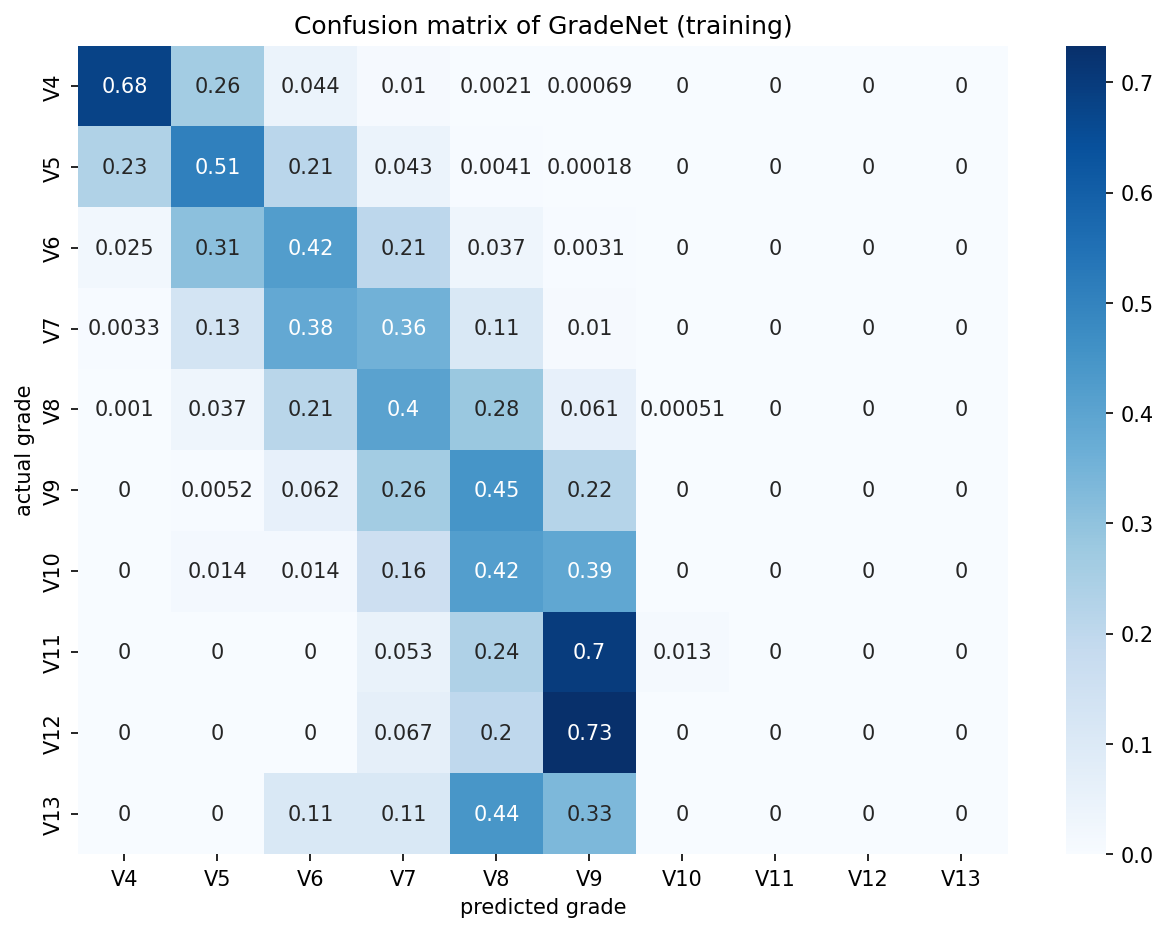

In [16]:
plot_confusion_matrix(Y_train, Y_train_pred, title = 'Confusion matrix of GradeNet (training)')

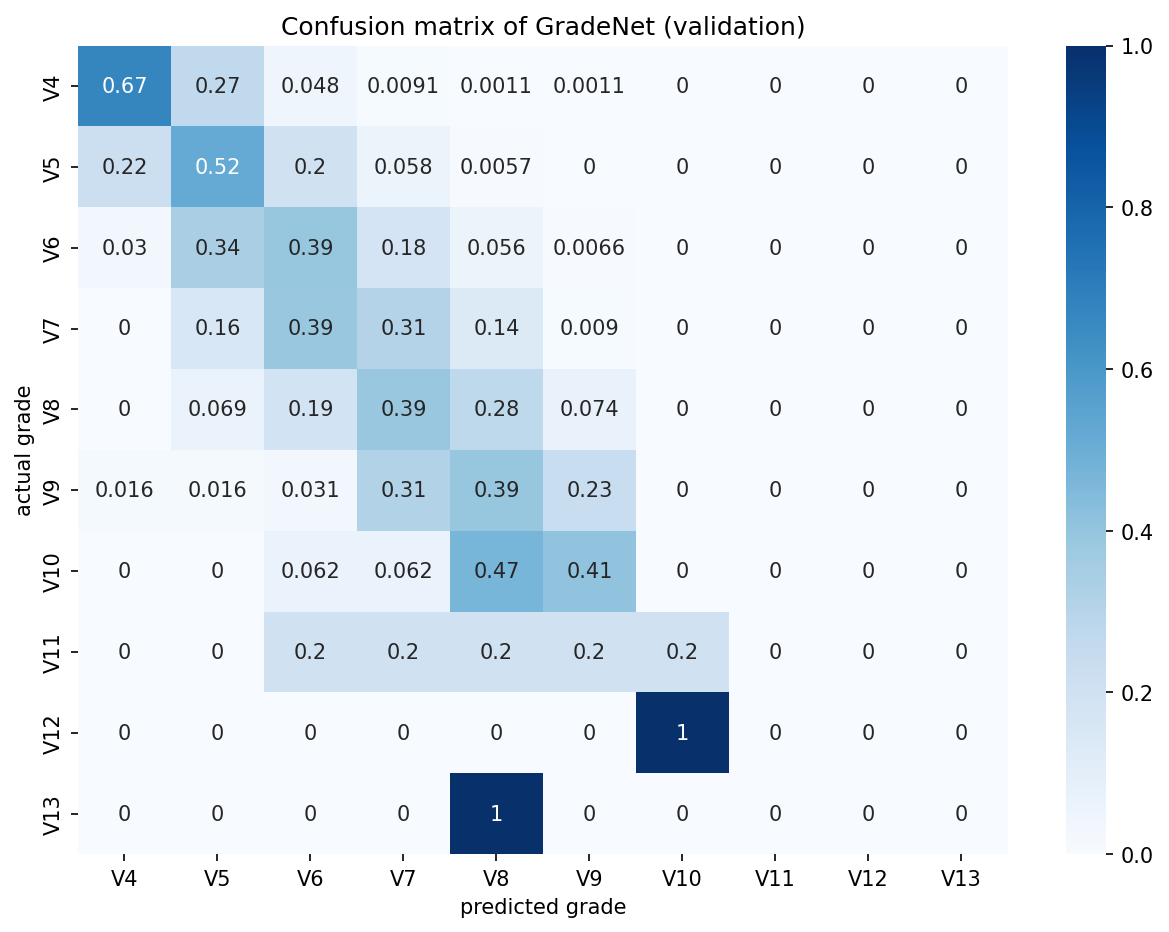

In [17]:
plot_confusion_matrix(Y_val, Y_val_pred, title = 'Confusion matrix of GradeNet (validation)')

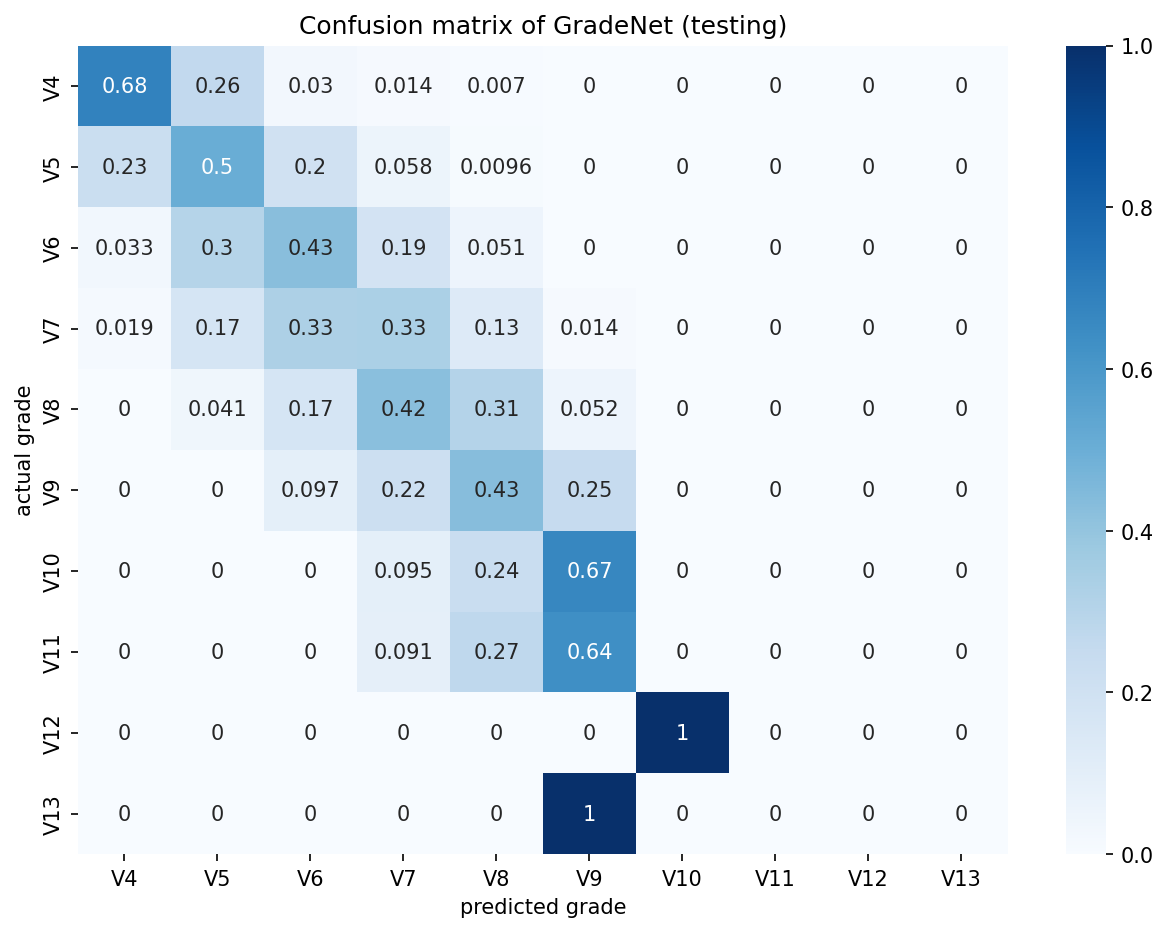

In [18]:
plot_confusion_matrix(Y_test, Y_test_pred, title = 'Confusion matrix of GradeNet (testing)')

### F1 score

In [45]:
F1_train = metrics.f1_score(Y_train, Y_train_pred, average = 'macro')
print(F1_train)

0.24664623433306435


In [44]:
F1_dev = metrics.f1_score(Y_val, Y_val_pred, average = 'macro')
print(F1_dev)

0.24059089408710793


In [43]:
F1_test = metrics.f1_score(Y_test, Y_test_pred, average = 'macro')
print(F1_test)

0.25049857488342536


### Accuracy and Rough accuracy

In [40]:
accuracy_train = compute_accuracy(Y_train, Y_train_pred)
print("Exactly accuracy rate of training set = %s" %accuracy_train[0])
print("+/-1 Accuracy rate of training set= %s" %accuracy_train[1])

Exactly accuracy rate of training set = 0.5075656099617999
+/-1 Accuracy rate of training set= 0.8992905690330902


In [41]:
accuracy_val = compute_accuracy(Y_val, Y_val_pred)
print("Exactly accuracy rate of dev set = %s" %accuracy_val[0])
print("+/-1 Accuracy rate of dev set = %s" %accuracy_val[1])

Exactly accuracy rate of dev set = 0.5016380016380017
+/-1 Accuracy rate of dev set = 0.8890253890253891


In [42]:
accuracy_test = compute_accuracy(Y_test, Y_test_pred)
print("Exactly accuracy rate of test set = %s" %accuracy_test[0])
print("+/-1 Accuracy rate of test set = %s" %accuracy_test[1])

Exactly accuracy rate of test set = 0.5062074489387265
+/-1 Accuracy rate of test set = 0.893872647176612


### RMSE

In [47]:
# 
rmse_train = np.sqrt(np.mean((Y_train-Y_train_pred)**2))
print(rmse_train)

rmse_val = np.sqrt(np.mean((Y_val-Y_val_pred)**2))
print(rmse_val)

rmse_test = np.sqrt(np.mean((Y_test-Y_test_pred)**2))
print(rmse_test)

0.9496685305956343
0.9807733998821858
0.970943498630605


### Classification report

In [27]:
sk_report_train = metrics.classification_report(
    digits=4,
    y_true=Y_train, 
    y_pred=Y_train_pred)
print(sk_report_train)

sk_report_val = metrics.classification_report(
    digits=4,
    y_true=Y_val, 
    y_pred=Y_val_pred)
print(sk_report_val)

sk_report_test = metrics.classification_report(
    digits=4,
    y_true=Y_test, 
    y_pred=Y_test_pred)
print(sk_report_test)

              precision    recall  f1-score   support

         0.0     0.7817    0.6795    0.7270      7285
         1.0     0.4852    0.5088    0.4967      5625
         2.0     0.2907    0.4219    0.3442      2586
         3.0     0.2607    0.3573    0.3014      1811
         4.0     0.4389    0.2820    0.3434      1961
         5.0     0.2984    0.2207    0.2537       580
         6.0     0.0000    0.0000    0.0000       209
         7.0     0.0000    0.0000    0.0000        76
         8.0     0.0000    0.0000    0.0000        15
         9.0     0.0000    0.0000    0.0000         9

    accuracy                         0.5076     20157
   macro avg     0.2556    0.2470    0.2466     20157
weighted avg     0.5299    0.5076    0.5133     20157

              precision    recall  f1-score   support

         0.0     0.7832    0.6750    0.7251       883
         1.0     0.4834    0.5178    0.5000       703
         2.0     0.2719    0.3920    0.3211       301
         3.0     0.2403 

/home/valsp/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/valsp/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/valsp/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v

In [28]:
if not REGRESSION:
    AUC_train = metrics.roc_auc_score(Y_train, Y_train_prob, multi_class= 'ovr', average="macro")
    print(AUC_train)

    AUC_val = metrics.roc_auc_score(Y_val, Y_val_prob, multi_class= 'ovr', average="macro")
    print(AUC_val)

    AUC_test = metrics.roc_auc_score(Y_test, Y_test_prob, multi_class= 'ovr', average="macro")
    print(AUC_test)